# Binance Trade Analysis

In [53]:
import pandas as pd
import numpy as np

df = pd.read_csv(r'C:\Users\anany\Desktop\Binance Trade Analysis\data\TRADES_CopyTr_90D_ROI.csv')

# Data Exploration and Cleaning

In [54]:
df.dropna(inplace=True)

In [55]:
print(df.columns)


Index(['Port_IDs', 'Trade_History'], dtype='object')


In [56]:
print(df['Trade_History'].iloc[0])


[{'time': 1718899656000, 'symbol': 'SOLUSDT', 'side': 'BUY', 'price': 132.537, 'fee': -0.9940275, 'feeAsset': 'USDT', 'quantity': 1988.055, 'quantityAsset': 'USDT', 'realizedProfit': 0.0, 'realizedProfitAsset': 'USDT', 'baseAsset': 'SOL', 'qty': 15.0, 'positionSide': 'LONG', 'activeBuy': True}, {'time': 1718899618000, 'symbol': 'DOGEUSDT', 'side': 'BUY', 'price': 0.12182, 'fee': -0.27979617, 'feeAsset': 'USDT', 'quantity': 1398.98088, 'quantityAsset': 'USDT', 'realizedProfit': 0.0, 'realizedProfitAsset': 'USDT', 'baseAsset': 'DOGE', 'qty': 11484.0, 'positionSide': 'LONG', 'activeBuy': False}, {'time': 1718899618000, 'symbol': 'DOGEUSDT', 'side': 'BUY', 'price': 0.12182, 'fee': -0.03949404, 'feeAsset': 'USDT', 'quantity': 197.47022, 'quantityAsset': 'USDT', 'realizedProfit': 0.0, 'realizedProfitAsset': 'USDT', 'baseAsset': 'DOGE', 'qty': 1621.0, 'positionSide': 'LONG', 'activeBuy': False}, {'time': 1718899616000, 'symbol': 'DOGEUSDT', 'side': 'BUY', 'price': 0.12182, 'fee': -0.00828375,

In [57]:
# Convert Trade_History column from string to list of dictionaries
import pandas as pd
import numpy as np
import ast  
df['Trade_History'] = df['Trade_History'].apply(ast.literal_eval)


In [58]:
df.head(5)

,Port_IDs,Trade_History
0,3925368433214965504,"[{'time': 1718899656000, 'symbol': 'SOLUSDT', ..."
1,4002413037164645377,"[{'time': 1718980078000, 'symbol': 'NEARUSDT',..."
2,3923766029921022977,"[{'time': 1718677164000, 'symbol': 'ETHUSDT', ..."
3,3994879592543698688,"[{'time': 1718678214000, 'symbol': 'ETHUSDT', ..."
4,3926423286576838657,"[{'time': 1718979615000, 'symbol': 'ETHUSDT', ..."


In [59]:
# Explode the list into separate rows
df = df.explode('Trade_History')

In [60]:
# Normalize the nested JSON structure into separate columns
trade_df = pd.json_normalize(df['Trade_History'])

In [61]:
# Ensure both DataFrames have the same index
df = df.reset_index(drop=True)
trade_df = trade_df.reset_index(drop=True)

# Merge with Port_IDs
df = pd.concat([df[['Port_IDs']], trade_df], axis=1)

In [62]:
# Convert timestamp from milliseconds to datetime
df['time'] = pd.to_datetime(df['time'], unit='ms')


In [63]:
# Convert necessary columns to numeric
df['realizedProfit'] = df['realizedProfit'].astype(float)
df['quantity'] = df['quantity'].astype(float)
df['qty'] = df['qty'].astype(float)
df['price'] = df['price'].astype(float)

In [64]:
df.head(5)

,Port_IDs,time,symbol,side,price,fee,feeAsset,quantity,quantityAsset,realizedProfit,realizedProfitAsset,baseAsset,qty,positionSide,activeBuy
0,3925368433214965504,2024-06-20 16:07:36,SOLUSDT,BUY,132.53700,-0.994027,USDT,1988.05500,USDT,0.0,USDT,SOL,15.0,LONG,True
1,3925368433214965504,2024-06-20 16:06:58,DOGEUSDT,BUY,0.12182,-0.279796,USDT,1398.98088,USDT,0.0,USDT,DOGE,11484.0,LONG,False
2,3925368433214965504,2024-06-20 16:06:58,DOGEUSDT,BUY,0.12182,-0.039494,USDT,197.47022,USDT,0.0,USDT,DOGE,1621.0,LONG,False
3,3925368433214965504,2024-06-20 16:06:56,DOGEUSDT,BUY,0.12182,-0.008284,USDT,16.56752,USDT,0.0,USDT,DOGE,136.0,LONG,True
4,3925368433214965504,2024-06-20 16:06:56,DOGEUSDT,BUY,0.12182,-0.046109,USDT,92.21774,USDT,0.0,USDT,DOGE,757.0,LONG,True


# Feature Engineering

In [65]:
# Function to compute financial metrics for each account
def compute_metrics(group):
    # ROI: Return on Investment = (Total Profit / Total Investment) * 100
    total_investment = group['quantity'].sum()
    total_profit = group['realizedProfit'].sum()
    roi = (total_profit / total_investment) * 100 if total_investment != 0 else 0

    # PnL: Total Profit and Loss
    pnl = total_profit

    # Win Positions: Number of trades with positive realized profit
    win_positions = (group['realizedProfit'] > 0).sum()

    # Total Positions: Total number of trades
    total_positions = len(group)

    # Win Rate: Percentage of winning trades
    win_rate = (win_positions / total_positions) * 100 if total_positions != 0 else 0

    # Maximum Drawdown (MDD): Max drop from a peak
    cumulative_pnl = group['realizedProfit'].cumsum()
    rolling_max = cumulative_pnl.cummax()
    drawdown = rolling_max - cumulative_pnl
    mdd = drawdown.max()

    # Sharpe Ratio: (Mean Return / Std Dev of Returns) [Assumption: risk-free rate is 0]
    mean_return = group['realizedProfit'].mean()
    std_return = group['realizedProfit'].std()
    sharpe_ratio = (mean_return / std_return) if std_return != 0 else 0

    return pd.Series({
        'ROI': roi,
        'PnL': pnl,
        'Sharpe_Ratio': sharpe_ratio,
        'MDD': mdd,
        'Win_Rate': win_rate,
        'Win_Positions': win_positions,
        'Total_Positions': total_positions
    })

# Apply function to each account
account_metrics = df.groupby('Port_IDs', group_keys=False).apply(compute_metrics, include_groups=False).reset_index()


print(account_metrics.head())


              Port_IDs       ROI          PnL  Sharpe_Ratio          MDD  \
0  3672754654734989568  0.476385   566.597660      0.185274    80.777037   
1  3733192481840423936  0.251099  2923.977200      0.060265  2743.120000   
2  3768170840939476993  8.779089   243.668899      0.424277     0.000000   
3  3784403294629753856  0.339819  2521.814305      0.106585   271.291981   
4  3786761687746711808  0.332072   205.021400      0.215150   123.460267   

    Win_Rate  Win_Positions  Total_Positions  
0  44.303797          210.0            474.0  
1  80.261248          553.0            689.0  
2  42.857143            6.0             14.0  
3  30.231405         1829.0           6050.0  
4  45.121951           37.0             82.0  


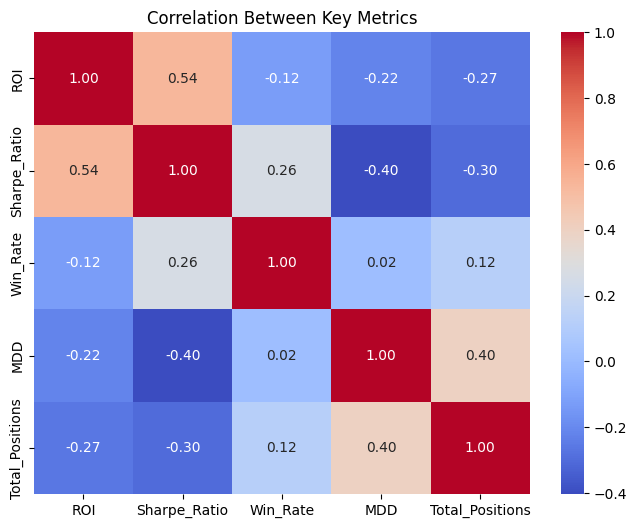

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation
correlation_matrix = account_metrics[['ROI', 'Sharpe_Ratio', 'Win_Rate', 'MDD', 'Total_Positions']].corr()

# Heatmap visualization
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Key Metrics")
plt.show()


In [75]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define features and target
features = ["ROI", "Sharpe_Ratio", "MDD"]
target = "PnL"

# Split data
X = account_metrics[features]
y = np.sign(account_metrics[target]) * np.log1p(abs(account_metrics[target]))


# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame to avoid indexing issues
X_scaled = pd.DataFrame(X_scaled, columns=features)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Ensure y_train is 1D
y_train = y_train.values.ravel()

# Train XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)

xgb_model.fit(X_train, y_train)  

# Get feature importance scores
feature_importance = xgb_model.feature_importances_

# Convert to dictionary
feature_importance_dict = dict(zip(features, feature_importance))

# Normalize weights to sum to 1
total_importance = sum(feature_importance_dict.values())
feature_weights = {feature: importance / total_importance for feature, importance in feature_importance_dict.items()}

print("Updated Feature Weights:", feature_weights)



Updated Feature Weights: {'ROI': 0.9030941128730774, 'Sharpe_Ratio': 0.05201401934027672, 'MDD': 0.04489186778664589}


# Ranking Algorithm

In [78]:
# Apply weights to create a performance score
account_metrics["Performance_Score"] = (
    (account_metrics["ROI"] * feature_weights["ROI"]) +
    (account_metrics["Sharpe_Ratio"] * feature_weights["Sharpe_Ratio"]) -
    (account_metrics["MDD"] * feature_weights["MDD"])  # Penalize high MDD
)

# Rank accounts based on score (higher is better)
account_metrics = account_metrics.sort_values(by="Performance_Score", ascending=False)

# Get the top 20 ranked accounts
top_20_accounts = account_metrics[["Port_IDs", "Performance_Score"]].head(20)

print(top_20_accounts)


                Port_IDs  Performance_Score
8    3826087012661391104          10.453191
2    3768170840939476993           7.950412
58   3977234346014419201           3.720761
111  4029507714735307777           3.100757
103  4023697881318718465           3.001468
81   4004713168329653760           2.914218
119  4030708912786799105           2.900401
102  4023697433751327232           2.892901
143  4039129759104249600           2.883170
112  4029749871687083265           2.881703
89   4013978721149559808           2.847284
131  4034786679304751616           2.798102
113  4030392204221219329           2.778202
122  4031408429897920512           2.764948
110  4029506971304830209           2.709475
140  4037717032428033792           2.483436
141  4037785885739608577           2.482240
61   3983074113875692800           2.474196
135  4037073643537925121           2.350440
39   3944658614777849089           1.902858
